### Import all necessary modules

In [1]:
import numpy as np
import sep

# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

### Read example image from FITS file 

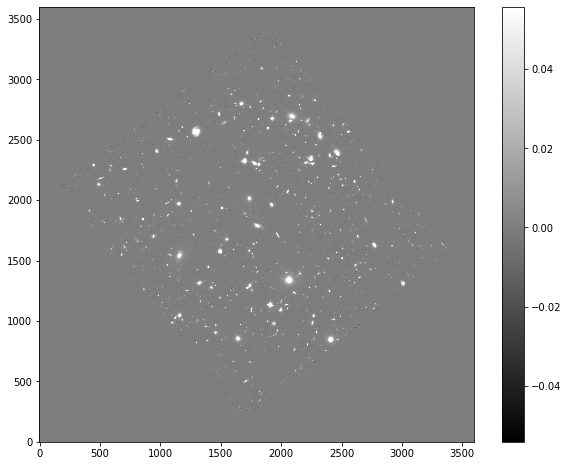

In [2]:
# read image into standard 2-d numpy array
img = fits.open('data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
data = img[0].data

# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

# Save image
plt.savefig('hubble-1.png')

### Background subtraction

In [5]:
# Convert array byte order
# (ValueError: Input array with dtype '>f4' has non-native byte order.)
data = data.byteswap(False).newbyteorder()

# measure a spatially varying background on the image
bkg = sep.Background(data)

# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


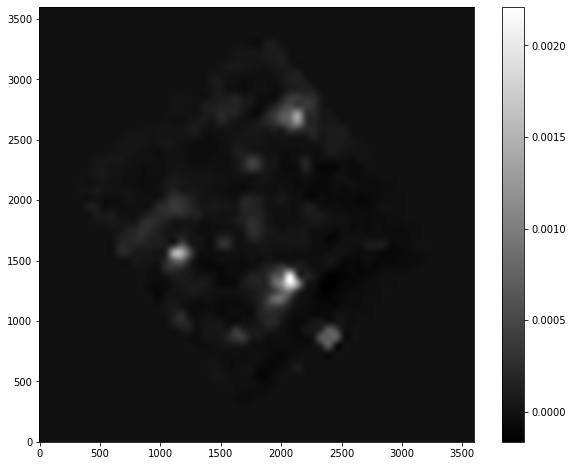

In [6]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

# Save image
plt.savefig('hubble-2.png')

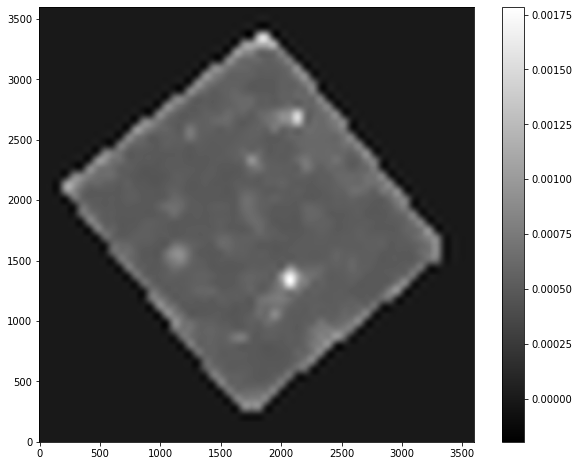

In [7]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

# Save image
plt.savefig('hubble-3.png')

In [8]:
# Subtract the background.
data_sub = data - bkg

### Object detection

In [9]:
# "setting the detection threshold to be a constant value of 1.5σ where σ is the global background RMS."
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

# how many objects were detected.
print('OBJECTS DETECTED: ', len(objects))

OBJECTS DETECTED:  8640


**Plotting takes ~40 seconds**

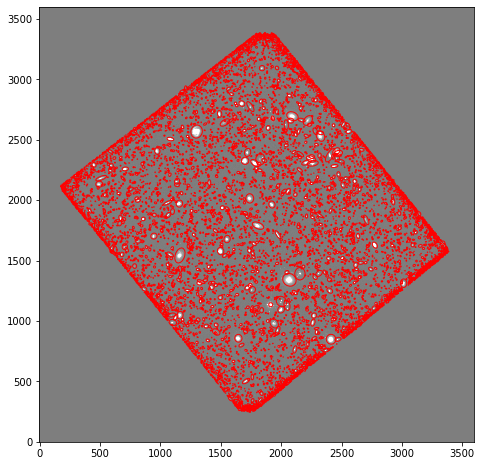

In [11]:
from matplotlib.patches import Ellipse

# plot background-subtracted image.
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', 
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object.
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
               width=6 * objects['a'][i],
               height=6 * objects['b'][i],
               angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
# Save the image as PNG.
plt.savefig('hubble-4.png')

In [12]:
# Available fields.
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

### Aperture Photometry

In [13]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [14]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


### Histogram

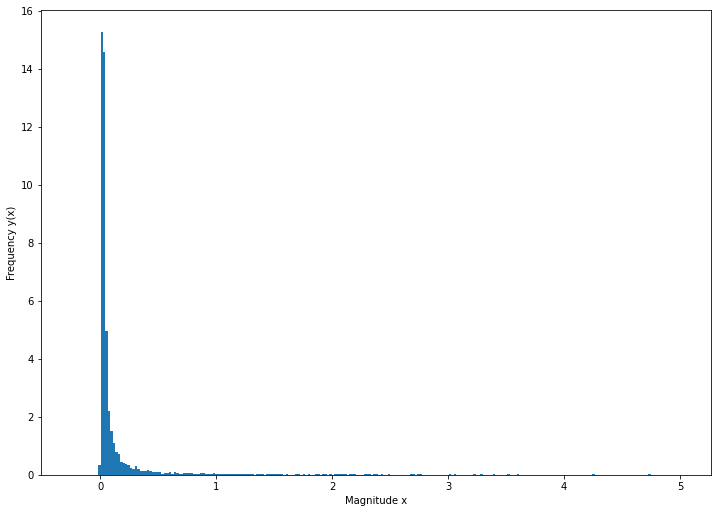

In [34]:
fig = plt.figure(figsize=(12,12))
histogram = plt.hist(flux, bins=250, range=[-0.25,5.0], density=True)
plt.gca().set_aspect(.25)
plt.xlabel('Magnitude x')
plt.ylabel('Frequency y(x)')

plt.show()